In [1]:

import cv2
import numpy as np
import os
from tqdm import tqdm

# load data
final_data = "C:/Users/HUY/Desktop/my_project/final_data"
synthetic_path = "C:/Users/HUY/Desktop/my_project/synthetic_data"

# tải dữ liệu dựa theo góc của dáng đi
def load_view(folder_paths, view):
    train, test = [], []
    train_view = []
    test_view = []
    for folder in (os.listdir(folder_paths)):
        if folder == "train":
            tr_labels = []
            for img in os.listdir(f"{folder_paths}/{folder}"):
                if view in img:
                    im = np.array(cv2.imread(f"{folder_paths}/{folder}/{img}", cv2.IMREAD_GRAYSCALE))
                    tr_labels.append(img[0:3])
                    train.append(im)
                    train_view.append(view)
        if folder == "test":
            te_labels = []
            for img in os.listdir(f"{folder_paths}/{folder}"):
                if view in img:
                    im = np.array(cv2.imread(f"{folder_paths}/{folder}/{img}", cv2.IMREAD_GRAYSCALE))
                    te_labels.append(img[0:3])
                    test.append(im)
                    test_view.append(view)
    # print(f"Hoàn thành tải dữ liệu lên từ {folder_paths} với góc {view} độ")
    return train, test, tr_labels, te_labels, train_view, test_view


# tải dữ liệu dáng đi với tất cả các góc
def load_data(view = "crossview"):
    
    views = ["000","018","036","054","072","090","108","126","144","162","180"]
    x_train, y_train = [], []
    x_test, y_test = [], []
    train_view, test_view = [], []
    
    if view in views:
        views = [view]
    
    for view in tqdm(views):
        x_rtrain_view, x_rtest_view, y_rtrain_view, y_rtest_view, rtrain_view, rtest_view = load_view(final_data, view)
        x_strain_view, x_stest_view, y_strain_view, y_stest_view, strain_view, stest_view = load_view(synthetic_path, view)
        
        x_train = x_train + x_rtrain_view + x_strain_view
        y_train = y_train + y_rtrain_view + y_strain_view
        x_test = x_test + x_rtest_view + x_stest_view
        y_test = y_test + y_rtest_view + y_stest_view
        train_view = train_view + rtrain_view + strain_view
        test_view = test_view + rtest_view + stest_view
        
    print(f"✅ Kích thước tập train và nhãn: {len(x_train)} và {len(y_train)}")
    print(f"✅ Kích thước tập test và nhãn: {len(x_test)} và {len(y_test)}")
    return x_train, y_train, x_test, y_test, train_view, test_view

x_train, y_train, x_test, y_test, train_view, test_view = load_data(view = "crossview")

100%|██████████| 11/11 [00:07<00:00,  1.57it/s]

✅ Kích thước tập train và nhãn: 4620 và 4620
✅ Kích thước tập test và nhãn: 3080 và 3080


In [2]:
# chuyển nhãn dán dữ thành mã hóa one-hot để đưa vào mô hình CNN
from sklearn.preprocessing import LabelEncoder

def to_categorical(y, num_classes=None):
    y = np.array(y, dtype=int)
    if num_classes is None:
        num_classes = np.max(y) + 1
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

# One-hot encoding
all_labels = np.concatenate([y_train, y_test])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

y_train_int = label_encoder.transform(y_train)
y_test_int = label_encoder.transform(y_test)

# one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_encoded = to_categorical(y_train_int, num_classes)
y_test_encoded = to_categorical(y_test_int, num_classes)

# Normailize
x_train = np.array(x_train).astype('float32') / 255.0
x_test = np.array(x_test).astype('float32') / 255.0
# OKE

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 44, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten và fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # tránh overfitting
model.add(Dense(10, activation='softmax'))  # 15 class output

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\HUY\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 42, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 19, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 19, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 7, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 7, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,898 (1.49 MB)

 Trainable params: 389,450 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',     # you can change to 'val_accuracy' if preferred
    patience=5,             # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # restore model weights from the epoch with the best value of the monitored quantity
)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(
    x_train, y_train_encoded,
    validation_data=(x_test, y_test_encoded),
    epochs = 30, # FIX HERE
    callbacks=[early_stop],
    batch_size=32,
    verbose=1
)

Epoch 1/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.1516 - loss: 2.6820 - val_accuracy: 0.1000 - val_loss: 6.8767
Epoch 2/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.2080 - loss: 2.0431 - val_accuracy: 0.1409 - val_loss: 6.7849
Epoch 3/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.2535 - loss: 1.9185 - val_accuracy: 0.1000 - val_loss: 8.5577
Epoch 4/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.3437 - loss: 1.7563 - val_accuracy: 0.2114 - val_loss: 2.3341
Epoch 5/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.4370 - loss: 1.5013 - val_accuracy: 0.3961 - val_loss: 1.7857
Epoch 6/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.6059 - loss: 1.0783 - val_accuracy: 0.7299 - val_loss: 0.8989
Epoch 7/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 0.7444 - loss: 0.7282 - val_accuracy: 0.8256 - val_loss: 0.5363
Epoch 8/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.8262 - loss: 0

In [5]:
# Đánh giá mô hình
test_loss, test_acc = model.evaluate(x_test, y_test_encoded, verbose=0)
print(f"\n✅ Test accuracy: {test_acc:.4f} - Test loss: {test_loss:.4f}")


✅ Test accuracy: 0.9802 - Test loss: 0.0626


conv2d_3 - filter shape: (3, 3, 1, 32)
conv2d_4 - filter shape: (3, 3, 1, 32)
conv2d_5 - filter shape: (3, 3, 1, 32)


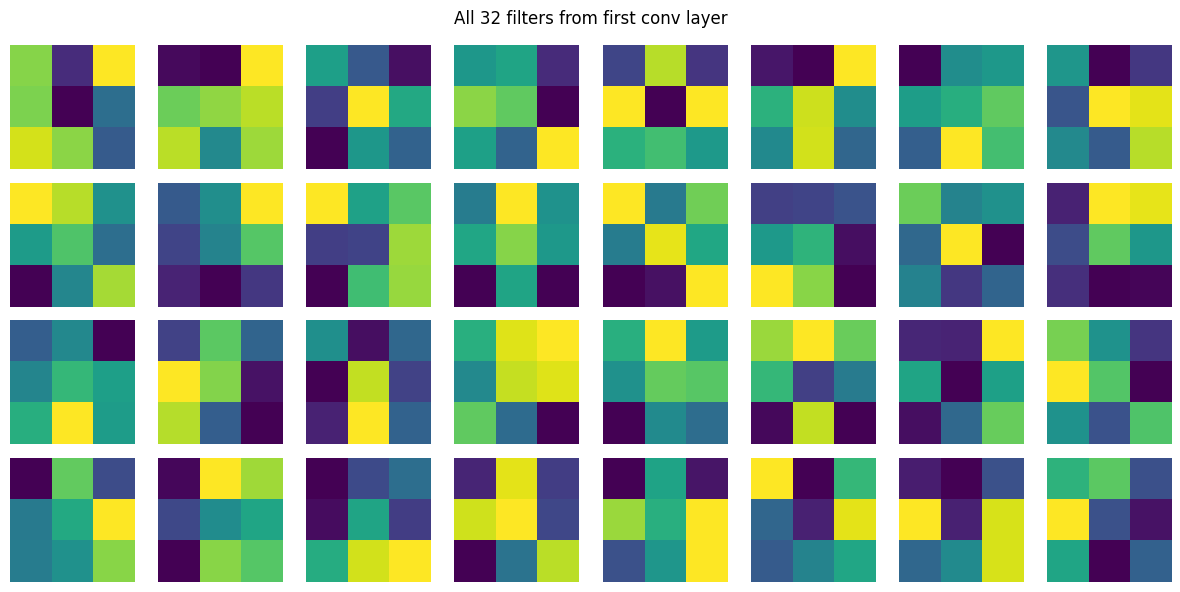

In [32]:
from matplotlib import pyplot as plt

for layer in model.layers:
    if 'conv' not in layer.name:
        continue

    print(f"{layer.name} - filter shape: {filters.shape}")

filters, _ = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# In tất cả 32 filters (vì chỉ có 1 channel, ta lấy [:,:,0,i])
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(filters[:, :, 0, i])
    ax.axis('off')
plt.suptitle("All 32 filters from first conv layer")
plt.tight_layout()
plt.show()

In [33]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    
    print(i, layer.name, layer.output.shape)

0 conv2d_3 (None, 62, 42, 32)
3 conv2d_4 (None, 29, 19, 64)
6 conv2d_5 (None, 12, 7, 128)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


c:\Users\HUY\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_92']
Received: inputs=Tensor(shape=(1, 64, 44))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


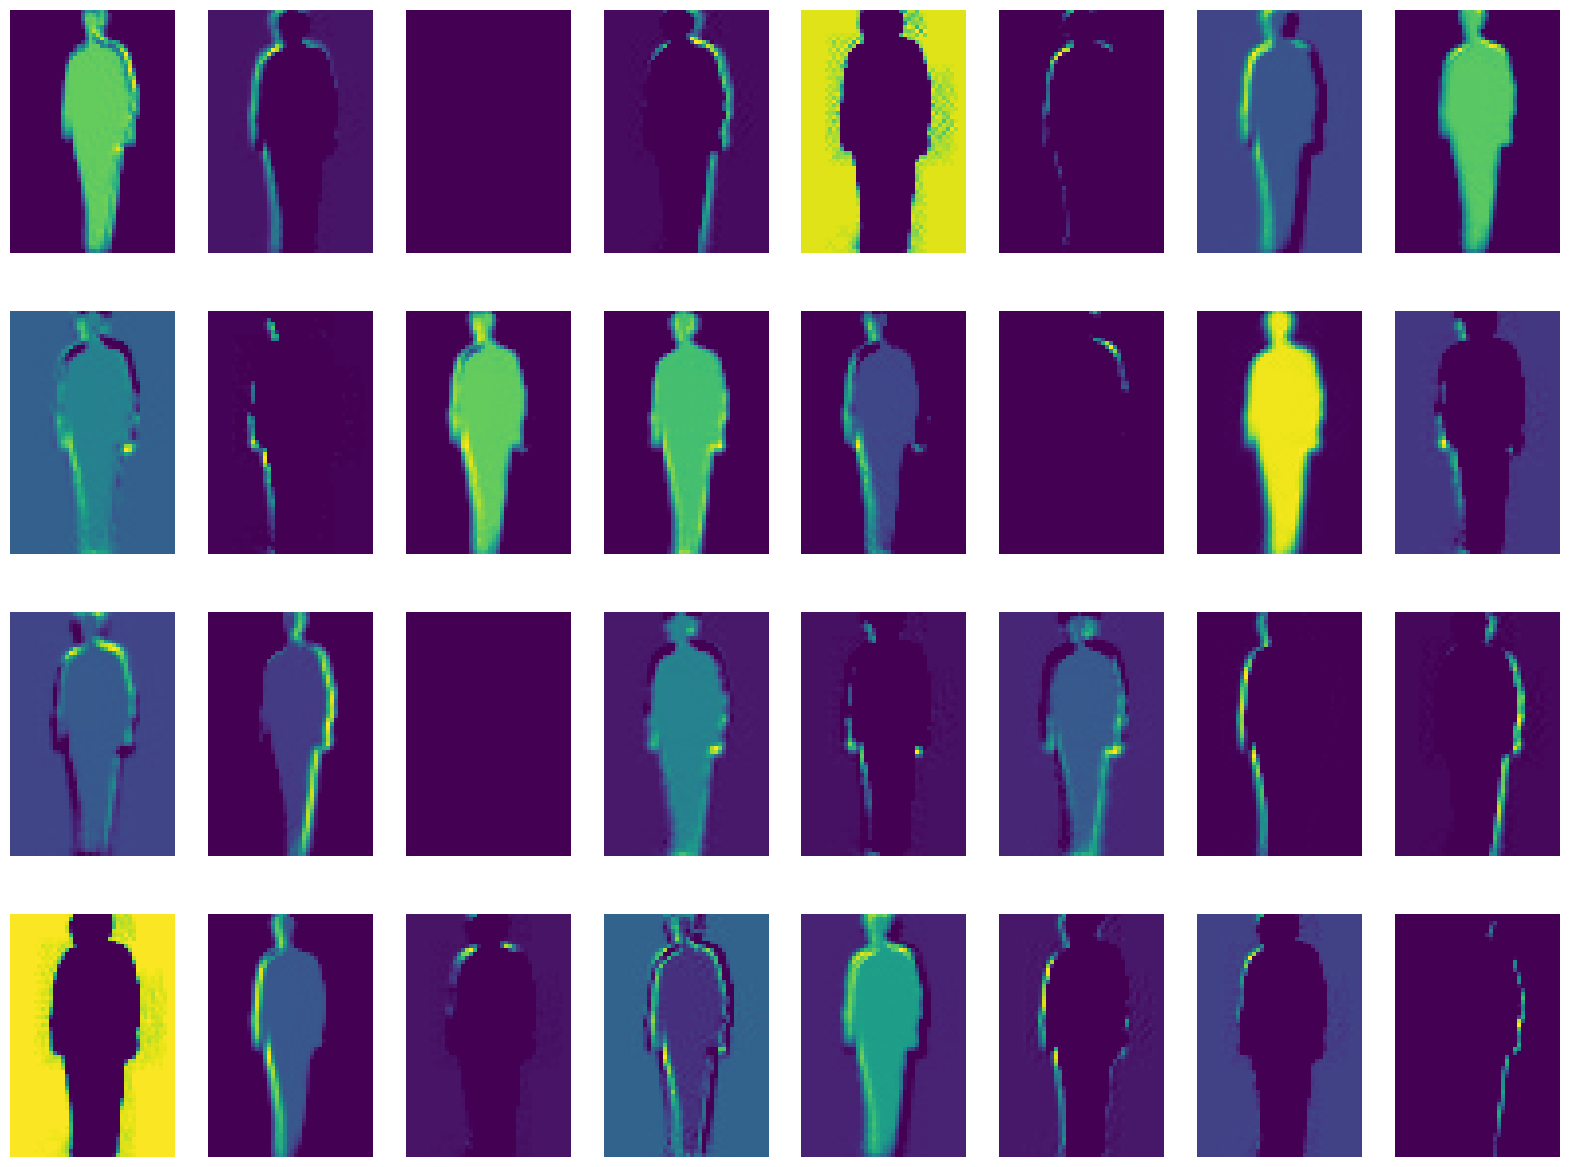

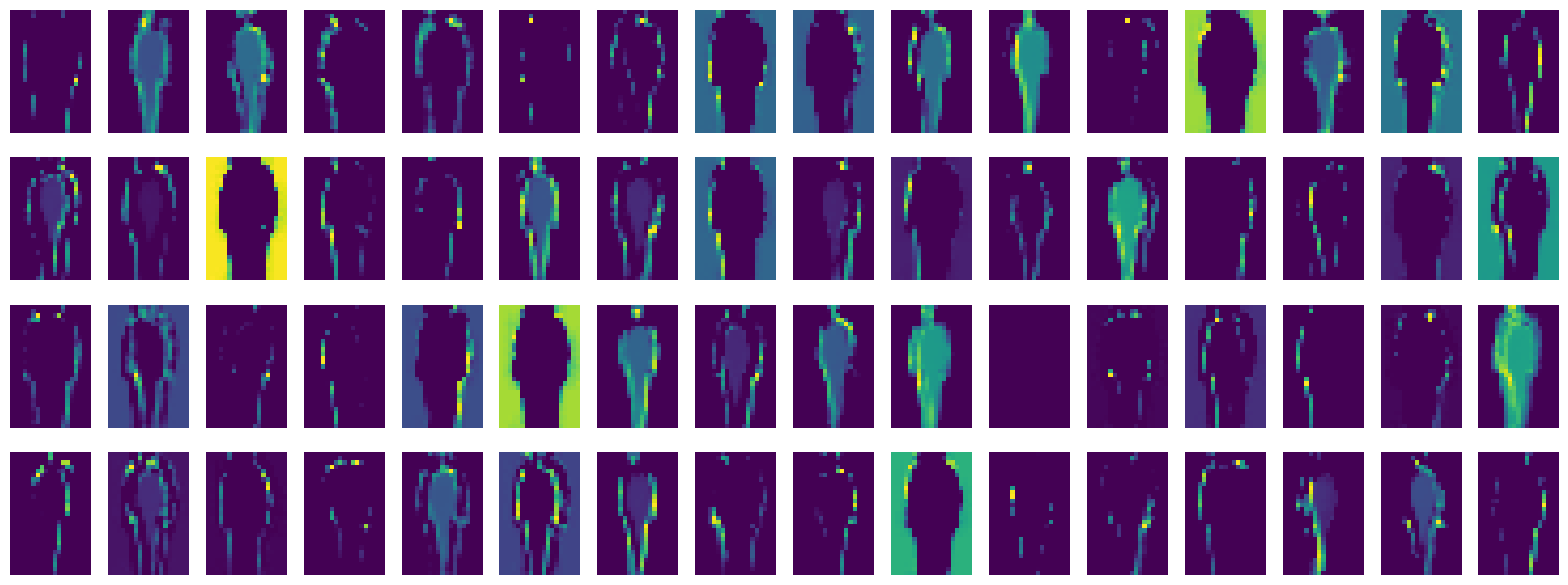

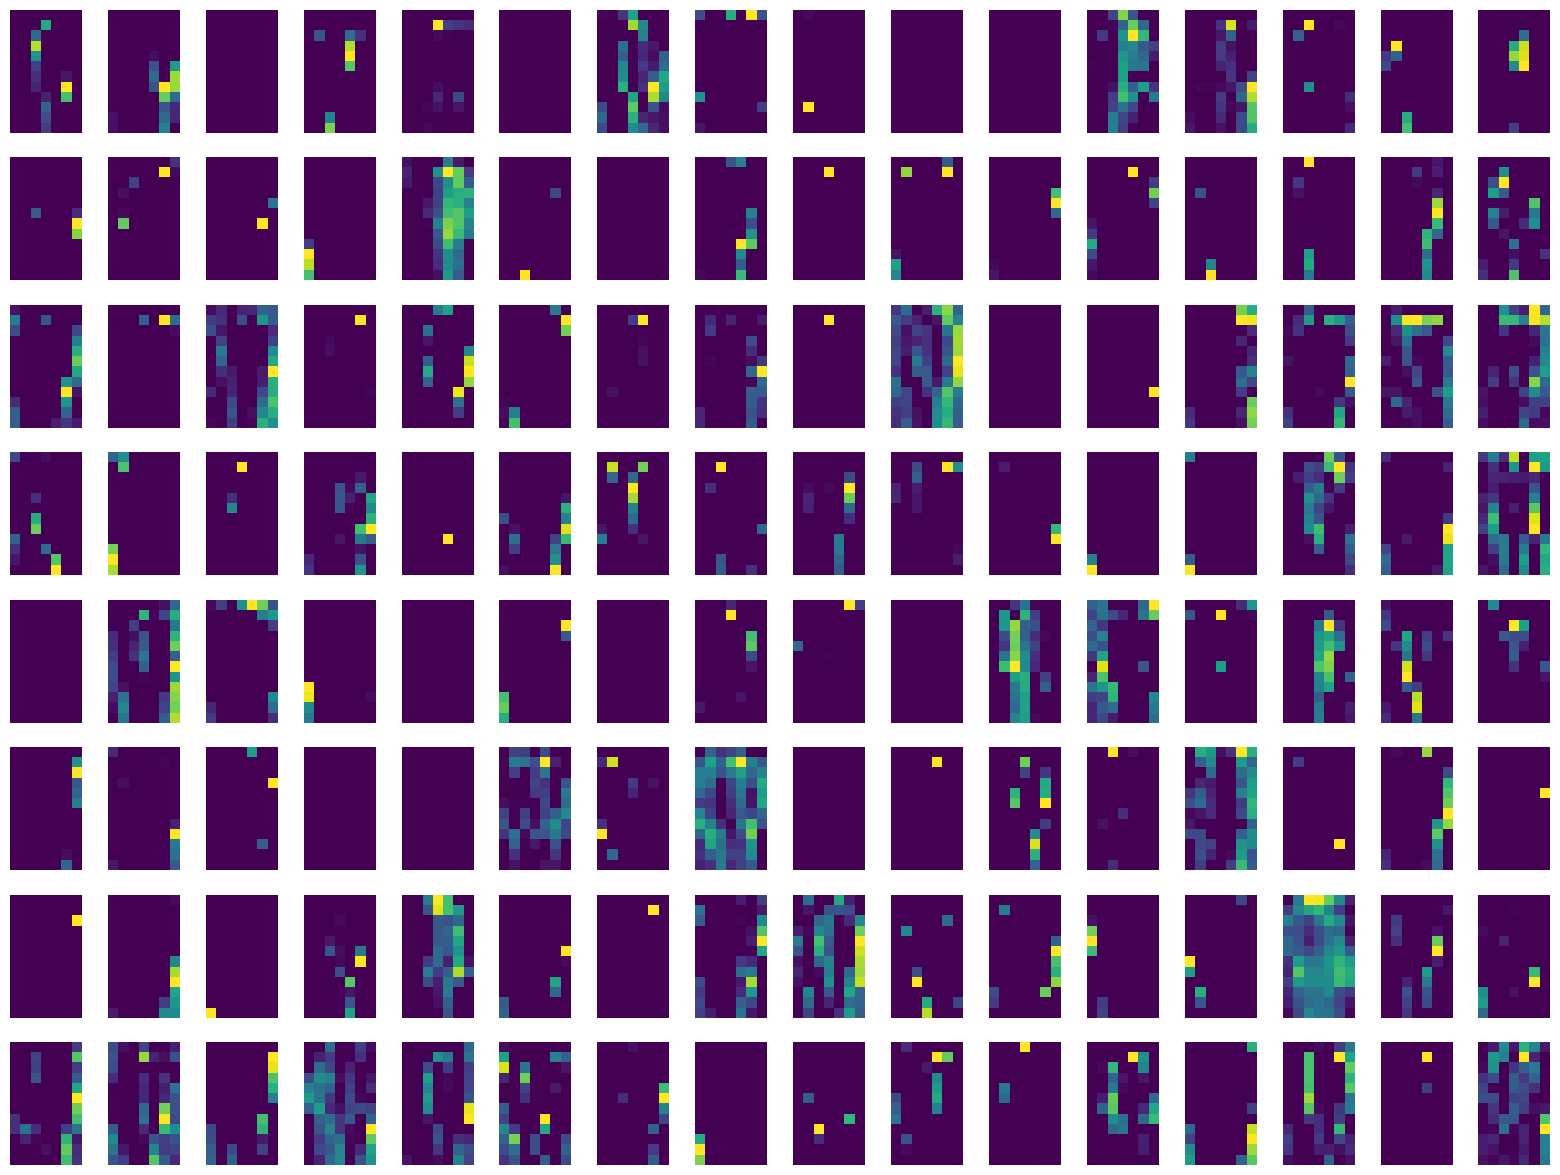

In [63]:
from tensorflow.keras.models import Model
from numpy import expand_dims
from matplotlib import pyplot

# First conv layer's features maps
img = x_test[0]
img = expand_dims(img, axis = 0)

model1 = Model(inputs=model.inputs , outputs=model.layers[0].output)
features = model1.predict(img)

fig = pyplot.figure(figsize=(20,15))
for i in range(1, features.shape[3]+1):
    pyplot.subplot(4,8,i)
    pyplot.imshow(features[0,:,:,i-1])
    pyplot.axis('off')

# Second conv layer's features maps
model2 = Model(inputs=model.inputs, outputs=model.layers[3].output)
features_1 = model2.predict(img)

fig1 = pyplot.figure(figsize=(20, 15))
for i in range(1, features_1.shape[3] + 1):
    pyplot.subplot(8, 16, i)
    pyplot.imshow(features_1[0, :, :, i - 1], cmap='viridis')
    pyplot.axis('off')

# Third conv layer's features maps
model3 = Model(inputs=model.inputs, outputs=model.layers[6].output)
features_2 = model3.predict(img)

fig2 = pyplot.figure(figsize=(20, 15))
for i in range(1, features_2.shape[3] + 1):
    pyplot.subplot(8, 16, i)  # vì có nhiều feature map hơn
    pyplot.imshow(features_2[0, :, :, i - 1], cmap='viridis')
    pyplot.axis('off')
    
pyplot.show()